# Setup

In [3]:
import pandas as pd
import numpy as np


# Preprocessing
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import re    
from bs4 import BeautifulSoup
import string
from emot.emo_unicode import UNICODE_EMOJI, EMOTICONS_EMO

# Modelling
from sklearn import model_selection
from sklearn import linear_model
from sklearn import metrics
from sklearn import naive_bayes

# Visualize
import seaborn as sns
import plotly.express as px
sns.set(rc={'figure.figsize':(15,9)})

# Data

In [4]:
south = pd.read_excel('../data/Tweets_etiqueta.xlsx', sheet_name='SouthwestAir')
south['airline'] = 'SouthwestAir'
south.head()

,Responsable,Texto,Sentimiento,airline
0,V,@SouthwestAir What about bike fees,0.0,SouthwestAir
1,V,@SouthwestAir I ❤️ SWA,1.0,SouthwestAir
2,V,@SouthwestAir Mask mandate tho,0.0,SouthwestAir
3,V,@SouthwestAir has ripped me off by delaying my...,-1.0,SouthwestAir
4,V,@SouthwestAir I’ll take my chances with @Delta...,0.0,SouthwestAir


In [5]:
jetblue = pd.read_excel('../data/Tweets_etiqueta.xlsx', sheet_name='JetBlue')
jetblue['airline'] = 'JetBlue'
jetblue.head()

,Responsable,Texto,Sentimiento,airline
0,V,@JustinMeyerKC @JetBlue @KCIAirport Cheers fro...,0.0,JetBlue
1,V,@caseycgolden @SpiritAirlines @JetBlue That so...,-1.0,JetBlue
2,V,"Hey @JetBlue, it’s been four days since you lo...",-1.0,JetBlue
3,V,@JustinMeyerKC @JetBlue Wil they be releasing ...,0.0,JetBlue
4,V,You can have your cake and eat it too when you...,0.0,JetBlue


In [6]:
df = pd.concat(    
    [
        south,
        jetblue
    ]
)

print(df.shape)

df = df.loc[df.Sentimiento.isin([1,-1]), ['Texto', 'Sentimiento','airline']]
df = df.drop_duplicates(subset='Texto')
df.columns = [x.lower() for x in df.columns]

df.head()

(6404, 4)


,texto,sentimiento,airline
1,@SouthwestAir I ❤️ SWA,1.0,SouthwestAir
3,@SouthwestAir has ripped me off by delaying my...,-1.0,SouthwestAir
5,@SouthwestAir I checked two bags and still had...,1.0,SouthwestAir
8,@SouthwestAir Just looked at flights to Seattl...,1.0,SouthwestAir
9,@Mike__Green @SouthwestAir And any last shred ...,-1.0,SouthwestAir


In [7]:
df['sentiment'] = df.sentimiento.apply(
    lambda x: 1 if x == 1 else 0
)

df.sentiment.value_counts().sum()

2695

<AxesSubplot:>

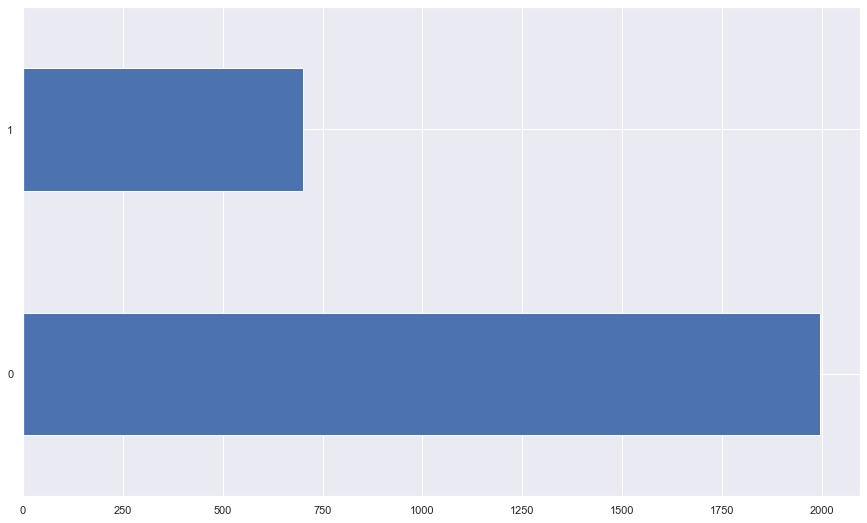

In [8]:
df.sentiment.value_counts().plot(kind='barh')


# EDA

In [9]:
punc = string.punctuation

In [10]:
df['word_count'] = df['texto'].apply(lambda x : len(x.split()))
df['char_count'] = df['texto'].apply(lambda x : len(x.replace(" ","")))
df['word_density'] = df['word_count'] / (df['char_count'] + 1)
df['punc_count'] = df['texto'].apply(lambda x : len([a for a in x if a in punc]))

df[['word_count', 'char_count', 'word_density', 'punc_count']].head()

,word_count,char_count,word_density,punc_count
1,4,19,0.200000,1
3,26,116,0.222222,4
5,18,93,0.191489,10
8,33,160,0.204969,7
9,8,49,0.160000,4


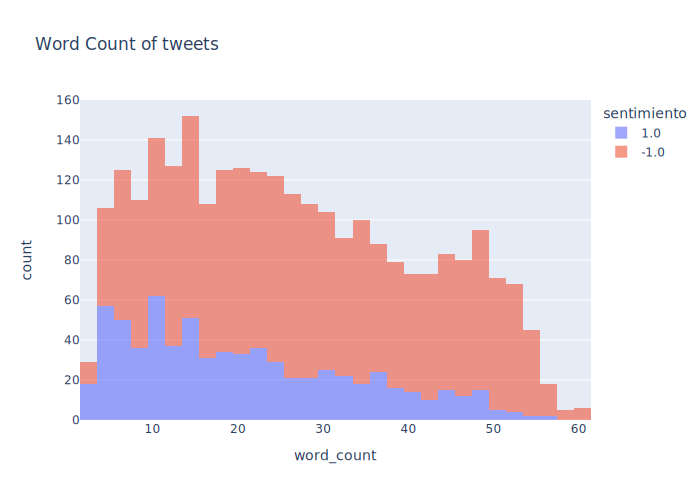

In [11]:
fig = px.histogram(
    df, 
    x="word_count", 
    color="sentimiento",
    title='Word Count of tweets'
    
)
fig.update_traces(opacity=0.6)
fig.show(renderer="svg")

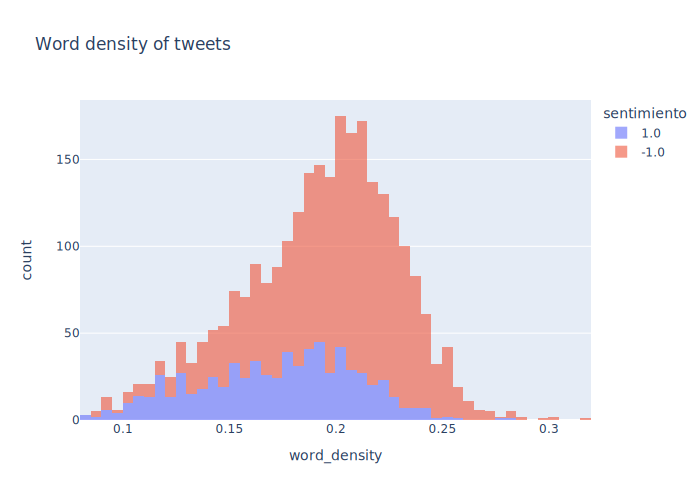

In [12]:
fig = px.histogram(
    df, 
    x="word_density", 
    color="sentimiento",
    title='Word density of tweets'
    
)
fig.update_traces(opacity=0.6)
fig.show(renderer="svg")

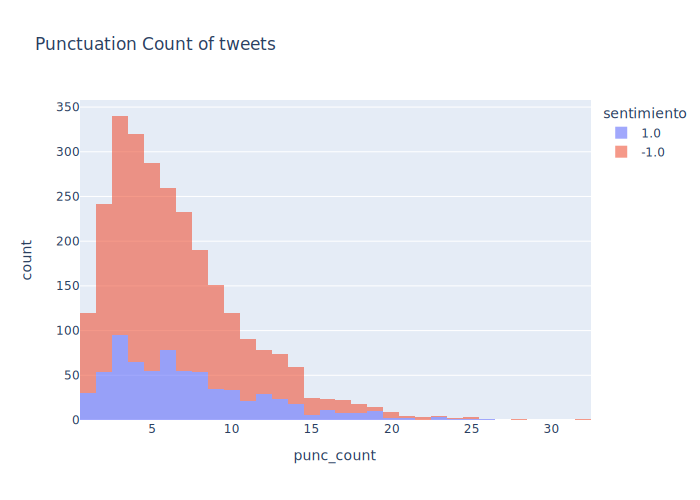

In [13]:
fig = px.histogram(
    df, 
    x="punc_count", 
    color="sentimiento",
    title='Punctuation Count of tweets'
    
)
fig.update_traces(opacity=0.6)
fig.show(renderer="svg")

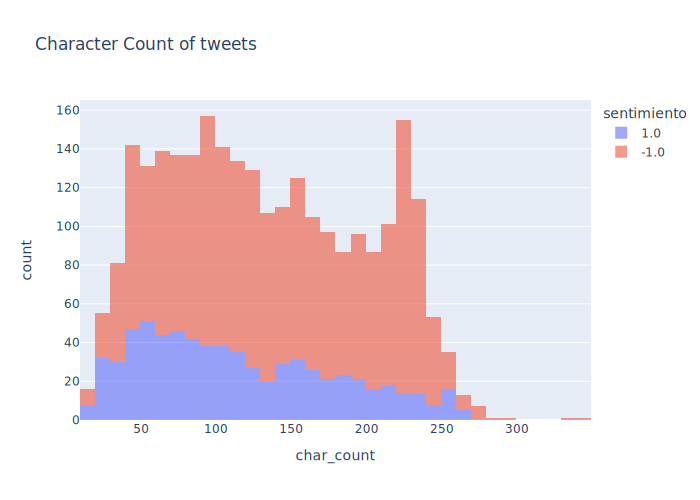

In [14]:
fig = px.histogram(
    df, 
    x="char_count", 
    color="sentimiento",
    title='Character Count of tweets'
    
)
fig.update_traces(opacity=0.6)
fig.show(renderer="svg")

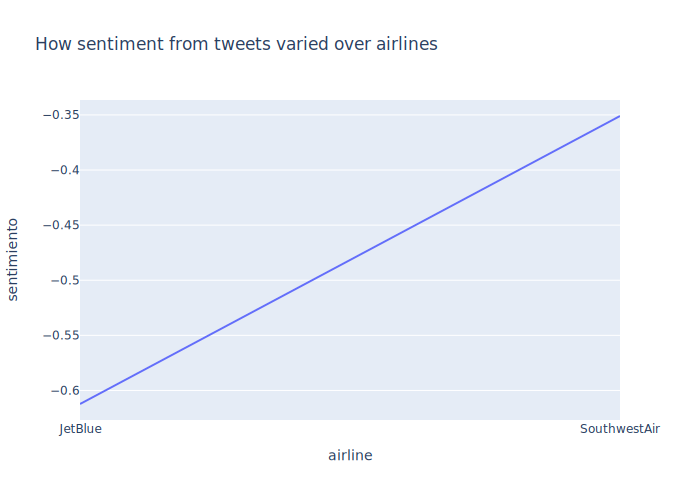

In [15]:
aggdf = df.reset_index().groupby(by=['airline']).agg({'sentimiento':'mean'}).reset_index()

fig = px.line(
    aggdf,
    x='airline', 
    y='sentimiento',
    title='How sentiment from tweets varied over airlines'
)
fig.show(renderer="svg")

# Preprocessing

In [16]:
def clean_tweet(x):
    clean_x = BeautifulSoup(x).get_text()
    clean_x = ' '.join(re.sub("(@[A-Za-z0-9]+)|(#[A-Za-z0-9]+)", " ", clean_x).split())
    clean_x = ' '.join(re.sub("(\w+:\/\/\S+)", " ", clean_x).split())
    clean_x = ' '.join(re.sub("[\.\,\!\?\:\;\-\=]", " ", clean_x).split())
    clean_x = clean_x.lower()

    
    for emot in UNICODE_EMOJI:
        clean_x = clean_x.replace(emot, "_".join(UNICODE_EMOJI[emot].replace(",","").replace(":","").split()))

    return clean_x
    

In [17]:
df['clean_text'] = df.texto.apply(clean_tweet)
# df['texto'].apply(lambda x : ' '.join(re.sub("(@[A-Za-z0-9]+)|(#[A-Za-z0-9]+)", " ", x).split()))

In [18]:
df.iloc[0,0], df.iloc[0,-1]

('@SouthwestAir I ❤️ SWA', 'i red_heart️ swa')

# Modelling

In [19]:
df["kfold"] = -1
df = df.sample(frac=1).reset_index(drop=True)
y = df.sentiment.values
kf = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=23)


for f, (t_, v_) in enumerate(kf.split(X=df, y=y)): 
    df.loc[v_, 'kfold'] = f

In [24]:
def model_in_folds(model_selected, model_name, preprocessing='CountVec'):
    
    accuracies = []
    recalls = []
    f1_scores = []
    folds = []
    aucs = []
    for fold_ in range(5):
        train_df = df[df.kfold != fold_].reset_index(drop=True)

        test_df = df[df.kfold == fold_].reset_index(drop=True)
        # Transformation
        if preprocessing == 'CountVec':
            count_vec = CountVectorizer(
                tokenizer=word_tokenize,
                token_pattern=None 
            )
            count_vec.fit(train_df.clean_text)
            xtrain = count_vec.transform(train_df.clean_text) 
            xtest = count_vec.transform(test_df.clean_text)
        elif preprocessing == 'tfidf':
            tfidf_vec = TfidfVectorizer(
                tokenizer=word_tokenize, 
                token_pattern=None, 
                ngram_range=(1, 3)
            )
            # fit count_vec on training data reviews
            tfidf_vec.fit(train_df.clean_text)
            # transform training and validation data reviews
            xtrain = tfidf_vec.transform(train_df.clean_text) 
            xtest = tfidf_vec.transform(test_df.clean_text)
            
        # Training
        model = model_selected
        model.fit(xtrain, train_df.sentiment) 
        
        # Scoring
        proba = model.predict_proba(xtest)[:,1]
        precision_, recall_, proba_ = metrics.precision_recall_curve(test_df.sentiment, proba)
        
        optimal_proba_cutoff = sorted(list(zip(np.abs(precision_ - recall_), proba_)), key=lambda i: i[0], reverse=False)[0][1]
        roc_predictions = [1 if i >= optimal_proba_cutoff else 0 for i in proba]
        preds = proba >= optimal_proba_cutoff
        
        # Performance measure
        accuracy = metrics.accuracy_score(test_df.sentiment, preds)
        recall = metrics.recall_score(test_df.sentiment, preds)
        f1_score = metrics.f1_score(test_df.sentiment, preds)
        auc = metrics.roc_auc_score(test_df.sentiment, proba)
        
        accuracies.append(accuracy)
        recalls.append(recall)
        f1_scores.append(f1_score)
        folds.append(fold_)
        aucs.append(auc)
            
    df_results = pd.DataFrame(
        {
            'fold':folds,
            'recall':recalls,
            'accuracy':accuracies,
            'f1_score':f1_scores,
            'auc':aucs
        }
    )
    
    df_results['preprocessing'] = preprocessing
    df_results['model'] = model_name
           
    return df_results

## Logistic regression

In [25]:
lst_results_1 = [
    model_in_folds(
        linear_model.LogisticRegression(solver='lbfgs', max_iter=1000),
                'LogisticRegression',
        'CountVec',
    ),
    model_in_folds(
        linear_model.LogisticRegression(solver='lbfgs', max_iter=1000),
        'LogisticRegression',
                'tfidf',
    )
]


In [26]:
results_data_1 = pd.concat(lst_results_1)
results_data_1.head()

,fold,recall,accuracy,f1_score,auc,preprocessing,model
0,0,0.728571,0.858998,0.728571,0.898434,CountVec,LogisticRegression
1,1,0.721429,0.855288,0.721429,0.895507,CountVec,LogisticRegression
2,2,0.735714,0.862709,0.735714,0.915163,CountVec,LogisticRegression
3,3,0.721429,0.855288,0.721429,0.889885,CountVec,LogisticRegression
4,4,0.692857,0.840445,0.692857,0.884945,CountVec,LogisticRegression


In [27]:
results_data_vf_1 = results_data_1.groupby(['model','preprocessing'])[['recall', 'accuracy', 'f1_score', 'auc']].mean()
results_data_vf_1

recall  accuracy  f1_score       auc
model              preprocessing                                        
LogisticRegression CountVec       0.720000  0.854545  0.720000  0.896787
                   tfidf          0.715714  0.852319  0.715714  0.895598

In [28]:
def plot_results(results_data, variable, model):
    results_data.pivot_table(
        index='fold',
        columns='preprocessing',
        values=variable
    ).plot(kind='bar', title=f'{variable} for {model}')


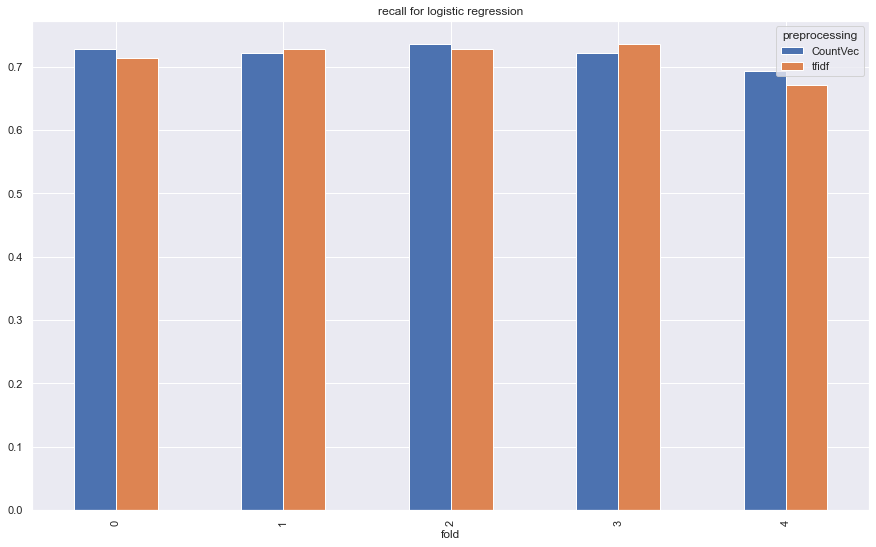

In [31]:
plot_results(results_data_1, 'recall', 'logistic regression')

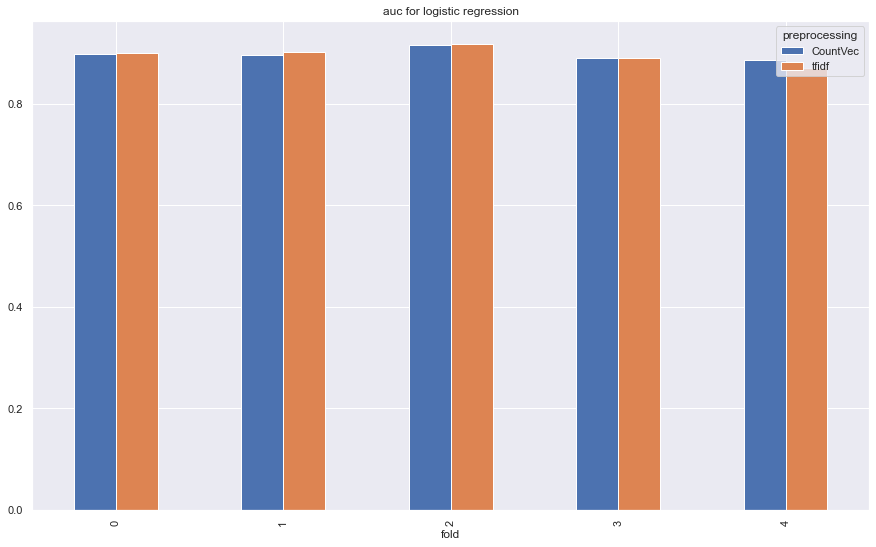

In [32]:
plot_results(results_data_1, 'auc', 'logistic regression')

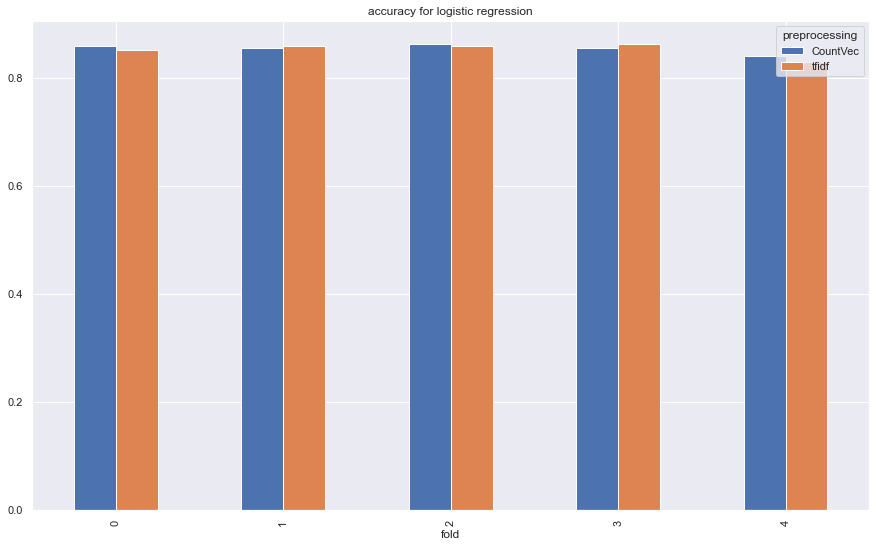

In [33]:
plot_results(results_data_1, 'accuracy', 'logistic regression')

## Naive Bayes

In [34]:
lst_results_2 = [
    model_in_folds(
        naive_bayes.MultinomialNB(),
                'Naive Bayes',
        'CountVec',
    ),
    model_in_folds(
        naive_bayes.MultinomialNB(),
        'Naive Bayes',
                'tfidf',
    )
]

In [35]:
results_data_2 = pd.concat(lst_results_2)
results_data_2.head()

,fold,recall,accuracy,f1_score,auc,preprocessing,model
0,0,0.707143,0.847866,0.707143,0.886762,CountVec,Naive Bayes
1,1,0.678571,0.833024,0.678571,0.881364,CountVec,Naive Bayes
2,2,0.721429,0.855288,0.721429,0.914859,CountVec,Naive Bayes
3,3,0.721429,0.855288,0.721429,0.890977,CountVec,Naive Bayes
4,4,0.678571,0.833024,0.678571,0.856284,CountVec,Naive Bayes


In [36]:
results_data_vf_2 = results_data_2.groupby(['model','preprocessing'])[['recall', 'accuracy', 'f1_score', 'auc']].mean()
results_data_vf_2

recall  accuracy  f1_score       auc
model       preprocessing                                        
Naive Bayes CountVec       0.701429  0.844898  0.701429  0.886049
            tfidf          0.641429  0.813729  0.641429  0.853783

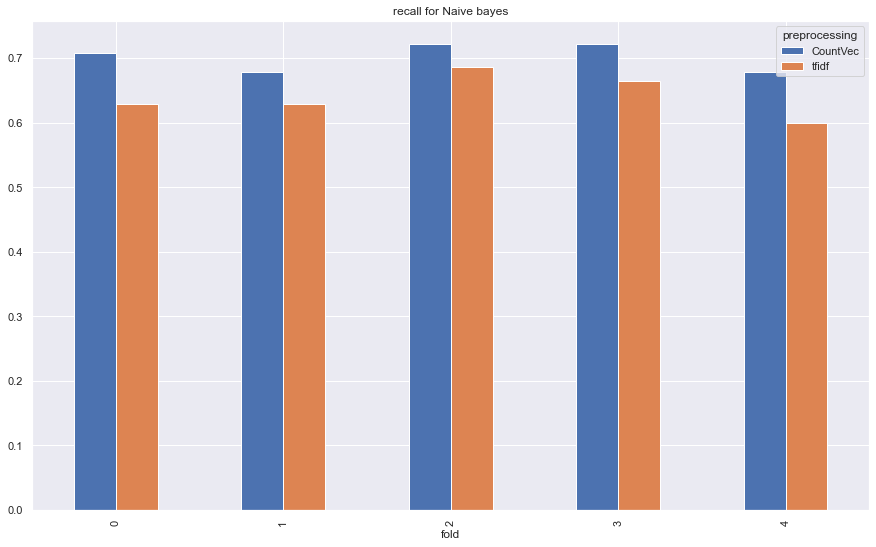

In [37]:
plot_results(results_data_2, 'recall', 'Naive bayes')

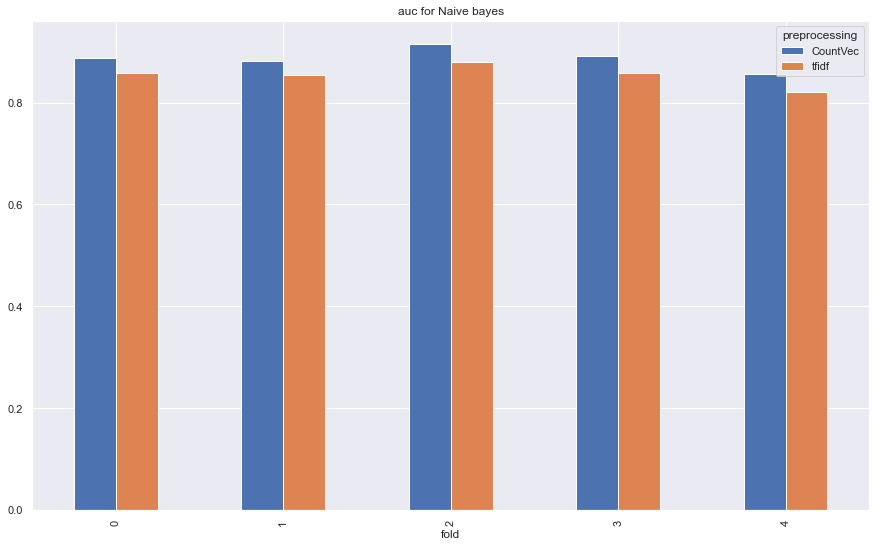

In [38]:
plot_results(results_data_2, 'auc', 'Naive bayes')

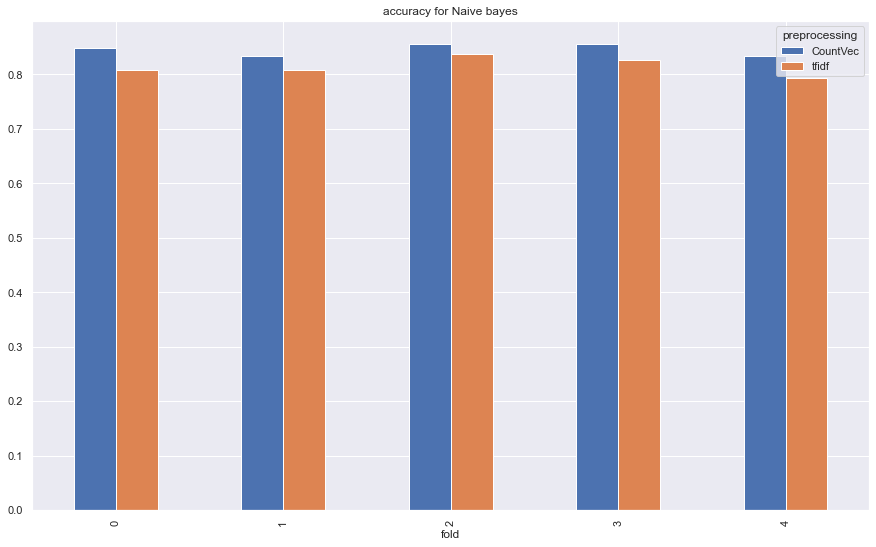

In [39]:
plot_results(results_data_2, 'accuracy', 'Naive bayes')

## Model comparison

In [40]:
results_data = pd.concat([results_data_vf_1,results_data_vf_2])
results_data.sort_values(by='auc')

recall  accuracy  f1_score       auc
model              preprocessing                                        
Naive Bayes        tfidf          0.641429  0.813729  0.641429  0.853783
                   CountVec       0.701429  0.844898  0.701429  0.886049
LogisticRegression tfidf          0.715714  0.852319  0.715714  0.895598
                   CountVec       0.720000  0.854545  0.720000  0.896787

# Final model

In [48]:
count_vec = CountVectorizer(
    tokenizer=word_tokenize,
    token_pattern=None 
)

count_vec = count_vec.fit(df.clean_text)
transformed_text = count_vec.transform(df.clean_text) 
final_model = linear_model.LogisticRegression(solver='lbfgs', max_iter=1000)
final_model.fit(transformed_text, df.sentiment)

LogisticRegression(max_iter=1000)

# Pipeline

In [58]:
def predict_sentiment(text):
    clean_text = [clean_tweet(text)]
    print(clean_text)
    transform_text = count_vec.transform(clean_text) 
    proba = final_model.predict_proba(transform_text)
    
    return proba
    

In [61]:
predict_sentiment('@airwest service was really bad. I would never buy a ticket with them again. #Bad service 😠')

['service was really bad i would never buy a ticket with them again service angry_face']


array([[0.96931605, 0.03068395]])

In [64]:
predict_sentiment('@airwest service was really good. I really recomend the airline 🥰')

['service was really good i really recomend the airline smiling_face_with_hearts']


array([[0.11248045, 0.88751955]])

## LSTM (falta implementarlo)

In [ ]:
import torch
import torch.nn as nn
class LSTM(nn.Module):
    def __init__(self, embedding_matrix):
        super(LSTM, self).__init__()
        # number of words = number of rows in embedding matrix 
        num_words = embedding_matrix.shape[0]
        # dimension of embedding is num of columns in the matrix
        embed_dim = embedding_matrix.shape[1]
        # we define an input embedding layer
        self.embedding = nn.Embedding( num_embeddings=num_words, embedding_dim=embed_dim
        )
        # embedding matrix is used as weights of
        # the embedding layer 
        self.embedding.weight = nn.Parameter(
            torch.tensor( 
                embedding_matrix, dtype=torch.float32
            ) 
        )
        # we dont want to train the pretrained embeddings
        self.embedding.weight.requires_grad = False # a simple bidirectional LSTM with
        # hidden size of 128 
        self.lstm = nn.LSTM( 
            embed_dim,
            128, 
            bidirectional=True, 
            batch_first=True,
        )
        # output layer which is a linear layer
        # we have only one output
        # input (512) = 128 + 128 for mean and same for max pooling 
        self.out = nn.Linear(512, 1)
        
    def forward(self, x):
        # pass data through embedding layer # the input is just the tokens
        x = self.embedding(x)
        # move embedding output to lstm
        x, _ = self.lstm(x)
        # apply mean and max pooling on lstm output
        avg_pool = torch.mean(x, 1) 
        max_pool, _ = torch.max(x, 1)
        # concatenate mean and max pooling
        # this is why size is 512
        # 128 for each direction = 256
        # avg_pool = 256 and max_pool = 256
        out = torch.cat((avg_pool, max_pool), 1)
        # pass through the output layer and return the output
        out = self.out(out)
        # return linear output
    return out

In [ ]:
def train(data_loader, model, optimizer, device): 
    # set model to training mode
    model.train()
    # go through batches of data in data loader
    for data in data_loader:
    # fetch review and target from the dict reviews = data["review"]
    targets = data["target"]
    # move the data to device that we want to use
    reviews = reviews.to(device, dtype=torch.long) targets = targets.to(device, dtype=torch.float)
    # clear the gradients
    optimizer.zero_grad()
    # make predictions from the model
    predictions = model(reviews)
    # calculate the loss
    loss = nn.BCEWithLogitsLoss()( predictions,
    targets.view(-1, 1) )
    
    # compute gradient of loss w.r.t.
    # all parameters of the model that are trainable 
    loss.backward()
    # single optimization step
    optimizer.step()

In [ ]:
def evaluate(data_loader, model, device):
    # initialize empty lists to store predictions # and targets
    final_predictions = []
    final_targets = []
    # put the model in eval mode
    model.eval()
    # disable gradient calculation
    with torch.no_grad():
    for data in data_loader:
    reviews = data["review"]
    targets = data["target"]
    reviews = reviews.to(device, dtype=torch.long) targets = targets.to(device, dtype=torch.float)
    # make predictions
    predictions = model(reviews)
    # move predictions and targets to list
    # we need to move predictions and targets to cpu too 
    predictions = predictions.cpu().numpy().tolist() targets = data["target"].cpu().numpy().tolist() final_predictions.extend(predictions) final_targets.extend(targets)
    # return final predictions and targets
    return final_predictions, final_targets

In [ ]:
import io
import torch
import numpy as np import pandas as pd
# yes, we use tensorflow
# but not for training the model! import tensorflow as tf
from sklearn import metrics
import config import dataset import engine import lstm
def load_vectors(fname):
    # taken from: https://fasttext.cc/docs/en/english-vectors.html
    fin = io.open(
        fname,
        'r', encoding='utf-8', newline='\n', errors='ignore'
    )
    n, d = map(int, fin.readline().split()) data = {}
    
    for line in fin:
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = list(map(float, tokens[1:])) 
        
    return data


def create_embedding_matrix(word_index, embedding_dict): 
    # initialize matrix with zeros
    embedding_matrix = np.zeros((len(word_index) + 1, 300))
    # loop over all the words
    for word, i in word_index.items():
    # if word is found in pre-trained embeddings, # update the matrix. if the word is not found, # the vector is zeros!
    if word in embedding_dict:
    embedding_matrix[i] = embedding_dict[word]
    # return embedding matrix
    return embedding_matrix

## Transfer learning

# Faltantes
- LSTM
- BERT